# [LAB07] 지도학습 > 예측 > 비선형 > 01-거리기반ㅣKNN

## KNN 개요 (1951년)

**K-최근접 이웃(K-Nearest Neighbors, KNN)**

새로운 관측치와 거리상 가장 가까운 k개의 이웃 데이터의 값을 이용해 목표값을 직접 계산하여 예측하는 비모수적(non-parametric) 알고리즘임.

연속형 값을 예측하는 회귀 모델과 분류 모델 모두를 지원함

### [1] 기본 아이디어

- 비슷한 입력값을 가진 데이터는 비슷한 결과값을 가질 것이라는 가정
- 전체 데이터를 대표하는 하나의 함수는 만들지 않음
- 예측 시점에 주변 데이터만을 참고하여 국소적으로 예측값을 결정
- 전역 모형(global model)이 아니라 **국소 모형(local model)**

**국소 모형이란**
- 전체 데이터를 대표하는 하나의 공통 수식을 만들지 않고
- 예측하려는 지점 주변의 일부 데이터만 사용해서 결과를 계산하는 방식

### [2] 작동순서

1. 새로운 관측치 입력
2. 기존 데이터와의 거리 계산
3. 가장 가까운 k개 이웃 선택
4. k개 이웃의 y값을 집계
5. 평균 또는 가중 평균으로 예측값 산출

거리 기준으로 이웃을 선택한 뒤 이웃들의 목표값(y)을 평균하여 예측
회귀 문제에서는 단순 평균, 거리 가중 평균(weighted average) 둘 다 사용 가능

### [3] 거리 계산 방법

KNN은 관측치 간 거리를 기준으로 이웃을 선택하는 모델이므로 거리 척도의 선택이 예측 결과에 직접적인 영향을 줌.

**유클리디안 거리 (Euclidean distance)**
- 직선 거리 개념에 해당
- 연속형 변수에서 가장 널리 사용됨
- 큰 값 차이에 민감하여 이상치의 영향이 큼
- 변수 단위가 다를 경우 왜곡 발생 가능
- 스케일링이 적용된 데이터에 적합

**맨해튼 거리 (Manhattan distance)**
- 축을 따라 이동한 거리의 합 개념
- 각 변수의 차이를 선형적으로 반영
- 유클리디안 대비 이상치 영향이 상대적으로 작음
- 고차원 데이터에서 비교적 안정적
- 변수 간 독립성이 강할 때 적합

**거리 기반 모델의 특성**
- 변수 스케일에 매우 민감
- 사전 스케일링(Standardization) 사실상 필수

### [4] 특징

| 구분 | 내용 |
|------|------|
| 모델 성격 | 명시적 학습 없음 |
| 함수 형태 | 회귀식 없음 |
| 비선형성 | 거리 기반 국소 평균으로 자연 발생 |
| 해석 | 전체 모형 해석 불가, 사례 중심 해석만 가능 |

### [5] 장단점

**장점**
- 비선형 관계 자동 반영
- 모형 가정 불필요
- 국소적 이상치 영향 제한

**단점**
- 예측 속도 느림
- 메모리 사용량 큼
- 차원 증가 시 성능 급격히 저하

## 준비작업

### [1] 패키지 참조

In [10]:
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

### [2] 데이터 가져오기 + 인덱스,타입변환

In [11]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("category")
origin["weekend"] = origin["weekend"].astype("category")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


### [3] 훈련, 검증 데이터 분리

In [12]:
df = origin
yname = "sales"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

## KNN 모델 적합

### [1] 주요 하이퍼 파라미터

| 파라미터명 | 핵심도 | 설명 | 기본값 | GridSearchCV 권장값 |
|-----------|--------|------|--------|-------------------|
| n_neighbors | ⭐⭐⭐ | 이웃 수 k (bias–variance 직접 제어) | 5 | [3, 5, 7, 9, 15, 25] |
| weights | ⭐⭐ | 이웃 가중치 방식 | 'uniform' | ['uniform', 'distance'] |
| metric | ⭐⭐ | 거리 계산 방식 | 'minkowski' | ['euclidean', 'manhattan', 'minkowski'] |
| p | ⭐⭐ | Minkowski 거리 차수 | 2 | [1, 2] |
| algorithm | | 최근접 탐색 알고리즘 | 'auto' | ['auto', 'ball_tree', 'kd_tree'] |
| leaf_size | | 트리 노드 크기 | 30 | [20, 30, 40] |
| n_jobs | | 병렬 처리 수 | None | [-1] |

### [2] 모형 적합

In [13]:
%%time
# 파이프라인 정의
pipe = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor())])

# 하이퍼파라미터 그리드
param_grid = {
    # 핵심 파라미터 ⭐⭐⭐
    "model__n_neighbors": [3, 5, 7, 9, 15, 25],
    "model__weights": ["uniform", "distance"],
    # 거리 정의 ⭐⭐
    "model__metric": ["euclidean", "manhattan", "minkowski"],
    "model__p": [1, 2],  # p=1: Manhattan, p=2: Euclidean
    # 탐색 알고리즘 / 성능
    "model__algorithm": ["auto", "ball_tree", "kd_tree"],
    "model__leaf_size": [20, 30, 40],
}

# GridSearchCV 설정
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)

# 학습
gs.fit(x_train, y_train)

# 최적 모델
best_model = gs.best_estimator_

# 결과 확인
print("Best params:", gs.best_params_)
print("CV best score:", gs.best_score_)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Best params: {'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}
CV best score: 0.6444866391028172
CPU times: user 538 ms, sys: 69.8 ms, total: 608 ms
Wall time: 3.15 s


## 성능평가

### [1] 성능평가 지표

In [14]:
y_pred = best_model.predict(x_test)

result_df = DataFrame(
    {
        "결정계수(R2)": r2_score(y_test, y_pred),
        "평균절대오차(MAE)": mean_absolute_error(y_test, y_pred),
        "평균제곱오차(MSE)": mean_squared_error(y_test, y_pred),
        "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
        "평균 절대 백분오차 비율(MAPE)": mean_absolute_percentage_error(y_test, y_pred),
        "평균 비율 오차(MPE)": np.mean((y_test - y_pred) / y_test * 100),
    },
    index=["성능지표"],
)

result_df

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
성능지표,0.634869,0.178029,0.052234,0.228547,0.010843,0.301152


### [2] 과적합 확인

#### 과적합 확인 함수

In [19]:
def hs_leanring_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    model_name = estimator.named_steps["model"].__class__.__name__
    print(f"=== Learning Curve: {model_name} ===")

    # neg RMSE → RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]

    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # 과소적합 기준선
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))
    std_y = y.std()
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # 판정 로직
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "일반화 양호"
    elif var_ratio > 0.15:
        status = "데이터 부족 / 분산 큼"
    else:
        status = "판단 유보"

    # 정량 결과 표
    result_df = DataFrame(
        {
            "지표": [
                "Train RMSE",
                "CV RMSE 평균",
                "CV RMSE 표준편차",
                "Train/CV 비율",
                "CV 변동성 비율",
                "판정 결과",
            ],
            "값": [
                final_train,
                final_cv,
                final_std,
                gap_ratio,
                var_ratio,
                status,
            ],
        }
    )
    display(result_df)

    # 학습곡선 시각화
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="CV RMSE",
    )

    ax.set_xlabel("훈련 데이터 수", fontsize=8, labelpad=5)
    ax.set_ylabel("RMSE", fontsize=8, labelpad=5)
    ax.set_title("학습곡선 (Learning Curve)", fontsize=12, pad=8)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

=== Learning Curve: KNeighborsRegressor ===


,지표,값
0,Train RMSE,0.0
1,CV RMSE 평균,0.219858
2,CV RMSE 표준편차,0.019821
3,Train/CV 비율,0.0
4,CV 변동성 비율,0.090153
5,판정 결과,과대적합 (variance 큼)


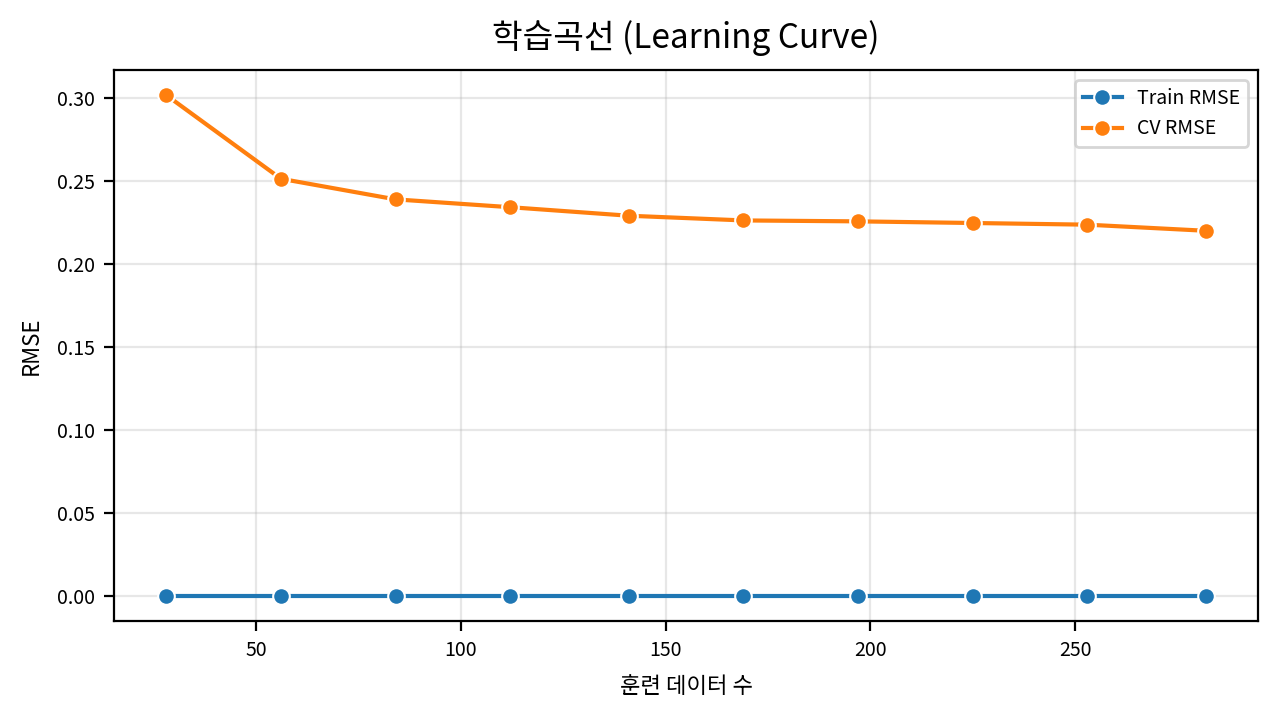

In [16]:
hs_leanring_cv(best_model, x, y)

## KNN의 모형 설명 - permutation_importance

변수 하나를 일부러 섞어서(permutation) 모형 성능이 얼마나 나빠지는지를 보고 그 변수의 중요도를 판단하는 방법

**이 변수를 망가뜨리면 예측 성능이 얼마나 떨어지는가?**

### 작동 원리 (순서)

1. 학습이 끝난 모델 고정
2. 기준 성능 계산 (예: R², RMSE)
3. 변수 하나 선택
4. 그 변수 값만 무작위로 섞음
5. 다시 예측
6. 성능 감소량을 중요도로 기록

### 특징

**장점**
- 모델 불문: KNN, SVR, 트리, NN 모두 가능
- 구조 독립: 계수·트리 구조 몰라도 됨
- 직관적: "섞었더니 성능 하락"

**단점**
- 방향성 없음: +인지 −인지 모름
- 상관 변수 문제: 비슷한 변수끼리 중요도 나눔
- 계산 비용: 반복 예측 필요

### KNN의 유일 선택지
- permutation_importance는 모든 비선형 모형이 사용할 수 있음
- KNN은 결과를 해석할 수 있는 방법이 permutation_importance 밖에 없음
- 하지만 다른 모델은 SHAP 분석이 더 좋은 선택지라서 사용하지 않음

### [1] 각 변수의 중요도 판별

In [17]:
perm = permutation_importance(
    estimator=best_model,
    X=x_test,
    y=y_test,
    scoring="r2",
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
)

# 결과 정리
perm_df = DataFrame(
    {
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std,
    },
    index=x_test.columns,
).sort_values("importance_mean", ascending=False)

perm_df

,importance_mean,importance_std
weekend,0.307000,0.055487
holiday,0.266704,0.054560
marketing_cost,0.081119,0.023776
rain_mm,0.048560,0.012672
avg_price,0.014858,0.010690
visitors,0.014034,0.011197
delivery_ratio,-0.002298,0.010469
temperature,-0.005803,0.010518


### [2] 변수 중요도 시각화

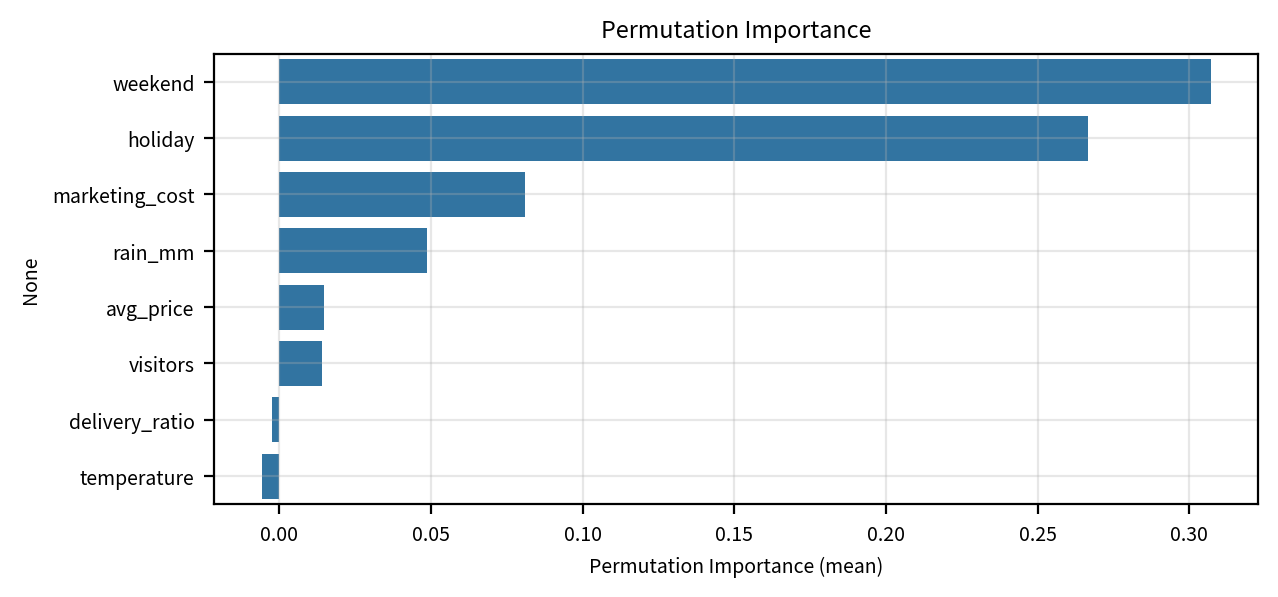

In [18]:
df = perm_df.sort_values(by="importance_mean", ascending=False)

figsize = (1280 / my_dpi, 600 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x="importance_mean", y=df.index)
ax.set_title("Permutation Importance")
ax.set_xlabel("Permutation Importance (mean)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

## 왜 KNN을 배우는가?

| 배우는 이유 | 핵심 |
|-----------|------|
| 최소 가정 모델 | 분포·함수 형태 가정 없음<br>"아무 가정도 안 하면 이 정도 성능"이라는 기준선 제공 |
| Bias–Variance 직관적 학습 | k ↓ → 과적합<br>k ↑ → 과소적합 |
| 전처리 중요성 체감 | 스케일링 유무에 따라 성능 급변<br>전처리가 모델보다 중요할 수 있음을 학습 |

### 정리

**KNN은 성능 좋은 모델이 아니라, 기준을 잡는 모델**

안 배우면 기준이 없고, 깊게 쓰면 손해

| 단계 | KNN |
|------|-----|
| 탐색 | ✅ |
| 베이스라인 | ✅ |
| 비교 기준 | ✅ |
| 최종 모델 | ❌ |